In [9]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt

# Using Principal Component Analysis to classify handwritten digits

The MNIST (National Institute of Standards and Technology) datasets contain images of handwritten numerical digits (the *M* stands for 'mixed,' since the samples are due to both U.S. Census Bureau employees and high school students). This database is commonly used to help develop image processing systems and to gauge performance of machine learning models. The full MNIST set contains roughly 6,000 labelled images of each digit '0' through '9'.


In this example, we will use principal component analysis (PCA) to analyze the MNIST dataset and construct a simple machine learning (ML) model to classify unlabelled images of digits.

These data are provided in two parts: `images` is a 2d numpy array containing 10,000 images of handwritten digits (a portion of MNIST). The first coordinate indexes the images themselves, each of which is represented by a 1d numpy array of 784 integers between 0 and 255 (think of each image as a $28\times 28$ matrix flattened into one long vector). `labels` is a 1d numpy array containing the integer label for each digit depicted in the corresponding image.

Here, the data provided in `images` comprise the *training set* for our machine learning model.

In [10]:
images = pd.read_csv('mnist_images_10k.csv.gz', compression='gzip', names=list(range(784))).to_numpy()
labels = np.genfromtxt('mnist_labels_10k.csv', dtype="int")

However, each image is a flattened row in the 2d array `images`. Let's take a look at the first image:

In [13]:
images[0].shape

(784,)

Throughout this exercise, it will sometimes be useful to consider each MNIST image as a 2d numpy array (rather than a 1d one) for visualization. You may achieve this via `numpy.reshape`, passing in `(28,28)` as the new shape. To undo this transformation, you may use `numpy.flatten`.

original shape: (784,)
plotting shape: (28, 28)
flattened shape: (784,)


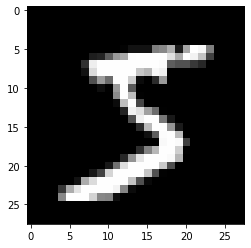

In [4]:
im = images[0]
print('original shape: {}'.format(im.shape))
im_square = im.reshape((28,28))
print('plotting shape: {}'.format(im_square.shape))
im_flat = im_square.flatten()
print('flattened shape: {}'.format(im_flat.shape))

plt.imshow(im_square, cmap="gray")

We can visualize the images as follows. To the human eye, many (but not all!) of these digits are clear; 'teaching' a computer to classify these digits requires some work.

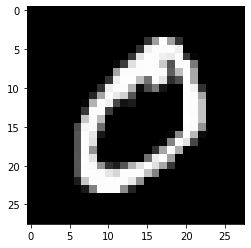

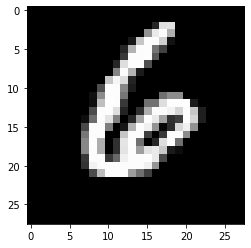

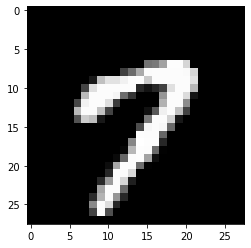

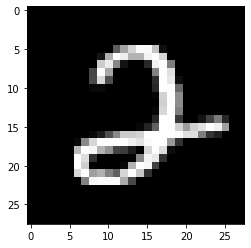

In [5]:
example_indices = [1,13,15,16]
for i in example_indices:
    plt.figure()
    plt.imshow(images[i].reshape((28,28)), cmap="gray")

We can then check the corresponding labels:

In [6]:
for i in example_indices:
    print('image {}: {}'.format(i,labels[i]))

image 1: 0
image 13: 6
image 15: 7
image 16: 2


## 1) Run PCA on the MNIST images:

Recall that PCA requires each axial mean to be 0. Compute the average of the given MNIST images and store the result as `mnist_avg`.

*Hint: Keep the image representations flattened, so the shape should be `(784,)`.*

In [46]:
#grade

averageArray = np.zeros((len(images[0]),))


for j in range(len(images[0])):
    pixelSum = 0
    for i in range(len(images)):
        pixelSum += images[i][j]
        
    averageArray[j] = pixelSum/10000
    
mnist_avg = averageArray

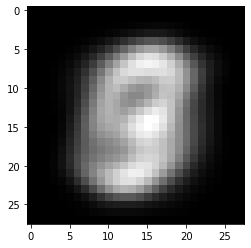

In [47]:
plt.imshow(mnist_avg.reshape((28,28)), cmap='gray')

Shift each of the (flat) MNIST images by `mnist_avg` so that the shifted dataset has an average equal to the 'image' composed of all 0 entries. This is a necessary step for PCA. Store the result as a 2d numpy array `images_sh`.

In [48]:
#grade
for i in range(len(images)):
    images[i] -= mnist_avg
    
images_sh = images

You have finished pre-processing the data and are now prepared to conduct PCA on the MNIST images. Compute the SVD of the numpy array representing the shifted MNIST images. Store the 1d numpy array of singular values as `S` and the 2d numpy array of right singular vectors (as columns) as `V`.

*Hint: Recall that `numpy.linalg.svd` returns the triple `U, S, Vt` where `U` stores $U$, `S` stores $\Sigma$ (as a 1d numpy array for the diagonal), and `Vt` stores $V^T$ from the SVD decomposition $U\Sigma V^T$ of the input matrix.*

Make sure to compute the reduced form of the SVD (`full_matrices=False`), otherwise the computation will take too long, and the auto-grader will abort.

In [63]:
#grade
U, S, Vt = la.svd(images_sh, full_matrices=False )

V = Vt.T

------------------------

## 2) Apply dimension reduction to PCA:

In the first part, we found the SVD decomposition of a matrix representation of the given MNIST images. However, these matrices remain very large. In practice, PCA is used to reduce the dimension of data (without compromising the crucial features), so we will pare down our eigenanalysis to make use of only the most 'principal' components and efficiently capture the distinguishing features of the handwritten digits.

We do this in part to avoid the *curse of dimensionality*, which degrades model accuracy as the number of feature dimensions increases beyond a certain threshold! Though our data is technically $784$-dimensional, we can intuit that  what the data represents (numerical digits) is lower-dimensional. We avoid overfitting our model, in part, by conducting this dimesion reduction and by only maintaining the principal components.

But how many should we keep?

Recall that in SVD decompositions, the singular values are ordered from largest to smallest magnitude. We only want to move forward with the highest magnitude singular values (and their corresponding singular vectors). In the plot below, we can see that the singular values gradually taper off to relatively low values. You may adjust the plot input to 'zoom in' on the earlier indices to see how quickly the values initially decrease.

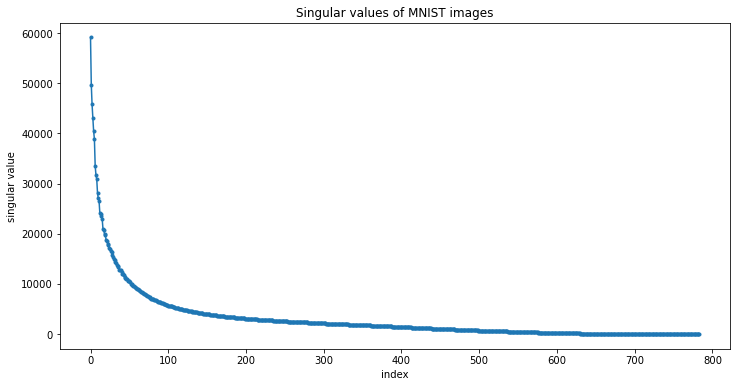

In [64]:
plt.figure(figsize=(12,6))
plt.plot(S, '.-')
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('Singular values of MNIST images')
plt.show()

One way of visualizing the same information is to "normalize" the singular values. In the following code snippet, we only show the first 50 singular values:

(0.0, 50.0)

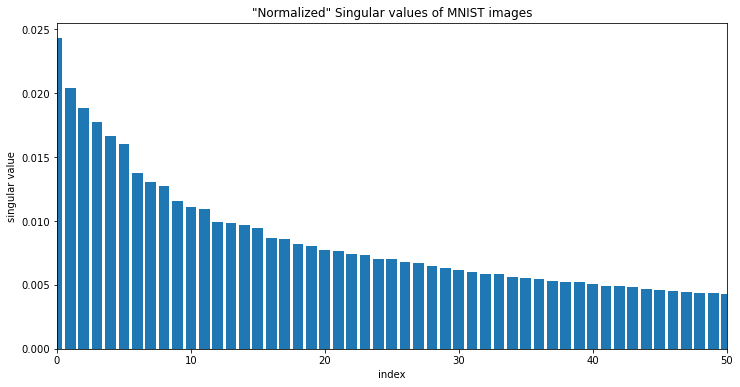

In [65]:
plt.figure(figsize=(12,6))
plt.bar(range(len(S)),S/sum(S))
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('"Normalized" Singular values of MNIST images')
plt.xlim(0,50)

We will now define a 1d array that has the cumulative sum of the normalized singular values.

First, compute the normalized singular values by dividing each element of `S` by the sum of all singular values.  Store this array as `S_norm`.

Then, compute the cumulative sums from this normalized array. You may find the function [numpy.cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) beneficial (alternatively, you could implement this using a quick for loop). 
Store the cumulative sum array in the variable `cum_var`.

In [103]:
#grade

S_norm = S/np.cumsum(S)[len(S) - 1]

cum_var = np.cumsum(S_norm)

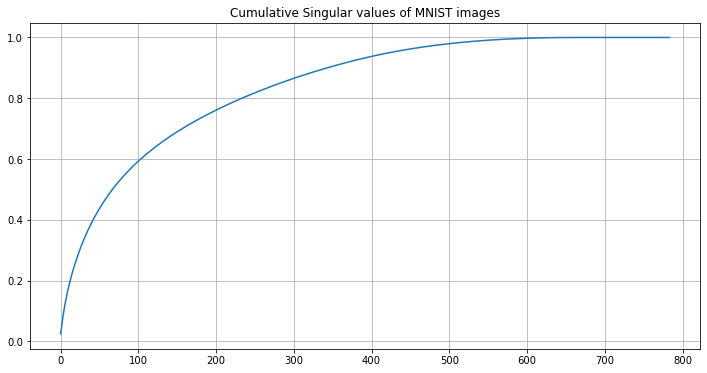

In [104]:
plt.figure(figsize=(12,6))
plt.plot(range(len(S)), cum_var)
plt.title('Cumulative Singular values of MNIST images')
plt.grid()

One way to read this plot is by identifying, for example, that the first 100 singular values contain 60% of the total information (this is called *explained variance*, and you can learn more about this by taking ML coursework). In some cases, we can set this percent as the threshold to find out the number of principal components that better represent the dataset.

Another approach is to find when the decay in the singular values produce a "kink". From the plot above (of normalized singular values), we can visually see that a kink first happens after the sixth singular value.

In essence, you want to find the earliest singular value which marks an increased difference from the previous one. Generally, the (absolute) difference between consecutive singular values should decrease, so identifying the earliest *increase* in these differences will capture any kinks like the one we see in the above plot.

You can compute the array of the difference between two consecutive singular values as:

In [105]:
S_diff = np.append(S_norm[0], np.abs(S_norm[1:] - S_norm[:-1]))

(0.0, 20.0)

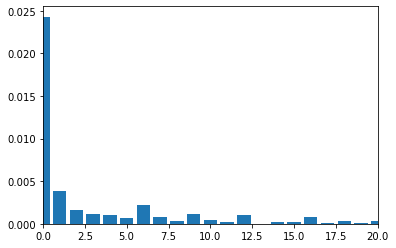

In [106]:
plt.bar(np.arange(len(S)), S_diff)
plt.xlim(0,20)

How can we find the first time the difference (stored in `S_diff`) stops being monotonically decreasing? We can use something very similar to the above method, by constructing an array `S_dec` of boolean values (True/False) based on whether or not a given difference is greater than the one before it. We then find the index of the first True value:

In [107]:
S_dec = (S_diff[1:] - S_diff[:-1] > 0)
for ind,x in enumerate(S_dec):
    if x:
        break
print(ind)

5


Here, `ind` indicates the array index for the last singular value before the "kink" occurs. 

We will denote `d = ind + 1` as the dimension of the reduced MNIST image features.  Note that this matches our previous visual inspection.

In [100]:
d = ind + 1
print(d)

6


Now, we want to reduce the dimension of our dataset in hopes that we can still easily capture the underlying features of the MNIST data. 

Write a function `reduce` which takes as input a 2d numpy array `A` and an integer value `m`, then returns as output the array `A` but in which the columns $j = m, m+1, m+2, ...$ are all set to 0. Recall that $j$ starts at zero (and hence we have the matrix `A` with $m$ non-zero columns). 

*Hint: Be careful that your function does not change the input matrix `A` (recall that Python is pass-by-object-reference); ways to ensure this include initializing `B` with `numpy.zeros_like(A)` or `A.copy()`, among others.*

```python
def reduce(A, m):
    # A is a 2d numpy array with shape (n,k)
    # compute B, a 2d numpy array, which has shape (n,k) and has the same first m columns as A
    # the remaining columns of B are all 0
    return B
```   

In [101]:
#grade

def reduce(A, m):
    
    B = A.copy()
    
    
    for i in range(m, len(A[0])):
        B[:, i] = 0 
        
    return B


This function `reduce` will enact the dimension reduction to our PCA. Call `reduce` on the right singular vectors array `V` from the first part and your computed dimension `d` from above; store the output as `Vd`.

In [102]:
#grade
Vd = reduce(V, d)

The remaining right singular vectors (i.e. the nonzero columns of `Vd`) are the principal components!

-----------------------

### 3) Building a nearest-neighbor classifier on MNIST:

The $k$-nearest neighbors (kNN) algorithm is a supervised machine learning classifier that, once trained, considers an unlabeled data point in the feature space and classifies that point according to the plurality of classifications given to the point's $k$-many nearest neighbors.

For this part, we will build the kNN model for $k=1$, so we reduce to the case of nearest-neighbor (NN) classification. We will consider an unlabelled MNIST digit and identify the labelled MNIST image lying closest to it in the feature space (i.e. the space of flattened array representations of images), then assign that image's classification to the unknown digit.

Compute the projection of each given MNIST image onto the principal components. Store the result as a 2d numpy array `images_pc` such that each row corresponds to the projection of a shifted MNIST image on the principal component space.

*Hint: Use the shifted data `images_sh` from the first part and the dimension-reduced right singular vector matrix `Vd` from the second part.*

In [110]:
#grade

images_pc = np.zeros((10000, 784))

for i in range(len(images)):
    
    images_pc[i] = images_sh[i] @ Vd
    

Now, we introduce an unlabelled MNIST image `unknown`, which is not contained in the given *training set* `images`. We can think of this unknown digit as being part of a *testing set* for our machine learning model. Our goal is to use our PCA to classify this image as one of the digits 0 through 9.

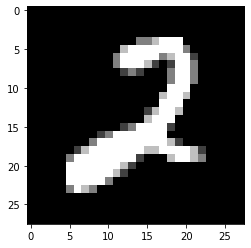

In [111]:
unknown = np.genfromtxt('unknown_image.csv')
plt.imshow(unknown.reshape((28,28)), cmap="gray")

Compute the projection of `unknown` onto the principal components as above, then store the result as `unknown_pc`.

In [155]:
#grade
unknown_pc = (unknown - mnist_avg) @ Vd

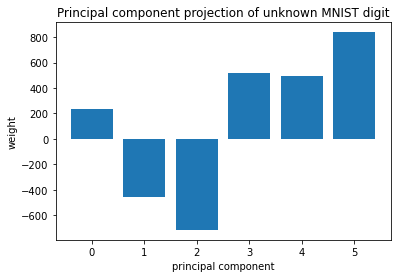

In [156]:
plt.figure()
plt.bar(list(range(d)),height=unknown_pc[:d])
plt.xlabel('principal component')
plt.ylabel('weight')
plt.title('Principal component projection of unknown MNIST digit')
plt.show()

We now must find the labelled MNIST image which lies closest to the unknown image. Here, 'closest' will be computed according to the Euclidean norm in the principal component space, as in Lesson 11 of the lab. Store the index of the nearest neighbor as `n`.

*Hint: Use `numpy.linalg.norm` to compute the Euclidean norm of the differences between the principal component projections of labelled MNIST images and the principal component projection of the unknown digit. Then use `numpy.argmin` to find the index of the labeled image corresponding to the smallest distance (the nearest neighbor).*

In [171]:
#grade

min_dif = la.norm(images_pc[0] - unknown_pc)

for i in range(1, len(images_pc)):
    if la.norm(images_pc[i] - unknown_pc) < min_dif:
        n = i
        min_dif = la.norm(images_pc[i] - unknown_pc)
        
print(n)


642


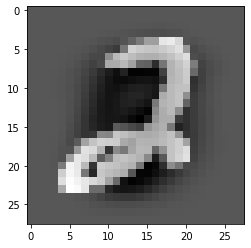

In [172]:
plt.imshow(images[n].reshape((28,28)), cmap="gray")

Finally, we assign the label of the nearest neighbor as the label for our unknown MNIST digit. Store this integer label as `unknown_label`.

In [173]:
#grade
unknown_label = 2

At your leisure, compare this label to the one you would have assigned to the unknown digit just by looking at it; do you agree with the conclusion of your machine learning model?

In [174]:
print(unknown_label)

2
